In [2]:
import os
import json
import time

import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 1000)
pd.options.display.float_format = '{:.5f}'.format

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib notebook

In [3]:
rpm = [0 for i in range(5000)]
df = pd.DataFrame()
df['rpm'] = rpm
df.loc[1000:1700] = 50
df.loc[2500:2800] = 50
df.loc[3000:4500] = 50
        
def generate_downlink(start, end, width, height, up):
    for i in range(start, end, width):
        if up:
            up = False
            df.loc[i:i+width] = height + 5
        else:
            up = True
            df.loc[i:i+width] = height - 5

generate_downlink(1100, 1490, 30, 50, up=True)
generate_downlink(2600, 2750, 30, 50, up=True)
generate_downlink(3100, 3430, 30, 50, up=True)
generate_downlink(3830, 4160, 30, 50, up=True)

generate_downlink(1190, 1250, 60, 50, up=False)
generate_downlink(1370, 1430, 60, 50, up=False)
generate_downlink(3920, 3980, 60, 50, up=False)

<AxesSubplot:xlabel='Time in seconds', ylabel='Device RPM'>

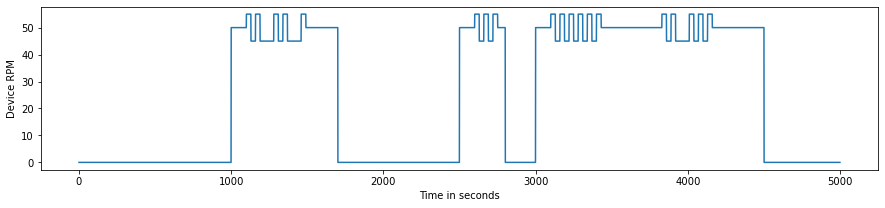

In [4]:
%matplotlib inline
plt.figure(figsize=(15,3))
plt.xlabel('Time in seconds')
plt.ylabel('Device RPM')
df['rpm'].plot()

In [34]:
df['rpm_changed'] = ((df['rpm'] != 0) & (df['rpm'].diff() > 0)).astype(int)
df['change_num'] = df['rpm_changed'].cumsum().astype(int)
df['change_counts_downlink_width'] = df['rpm_changed'].rolling((2*60), center=False).sum()
df['change_counts_downlink_width_reverse'] = df[::-1]['rpm_changed'].rolling((2*60), center=False).sum()[::-1]
df['downlink'] = ((df['change_counts_downlink_width'] > 0) & (df['change_counts_downlink_width_reverse'] > 0)).astype(int)

<AxesSubplot:>

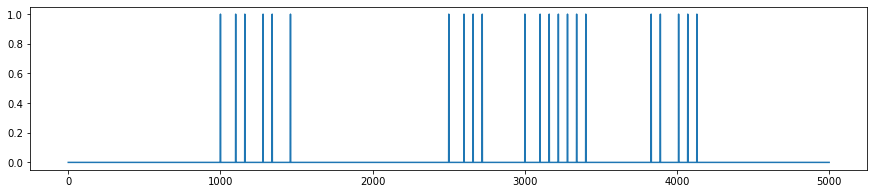

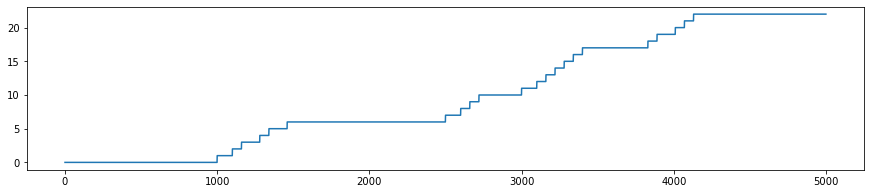

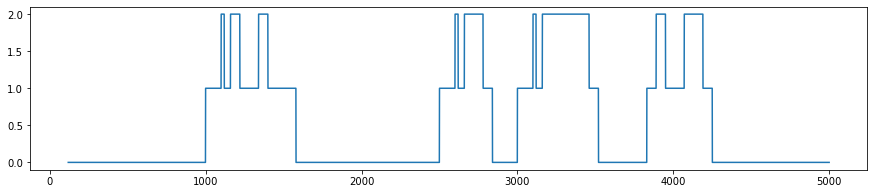

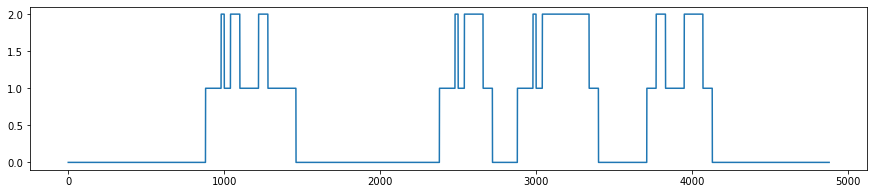

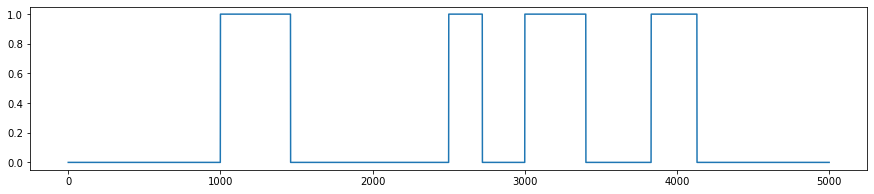

In [37]:
%matplotlib inline

plt.figure(figsize=(15,3))
df['rpm_changed'].plot()
plt.figure(figsize=(15,3))
df['change_num'].plot()
plt.figure(figsize=(15,3))
df['change_counts_downlink_width'].plot()
plt.figure(figsize=(15,3))
df['change_counts_downlink_width_reverse'].plot()
plt.figure(figsize=(15,3))
df['downlink'].plot()

In [11]:
def get_change_counts(df):
    df['sample_trace_sp'].ffill(inplace=True)
    df['sample_trace_changed'] = ((df['sample_trace_sp'].diff().apply(abs) > 20) #sp changed by at least 20
                         & (df['sample_trace_sp'].rolling(5).min() > 5) #sp did not start or end at 0
                         & (df['sample_trace_sp'][::-1].rolling(5).min()[::-1] > 5)
                         & (df['sample_condition'] == 0)
                         & (df['sample_state'] == 1)).astype(int) #we are currently not in-slips
    df['sample_trace_changed_general'] = ((df['sample_trace_sp'].diff().apply(abs) > 3) 
                         & (df['sample_condition'] == 0)
                         & (df['sample_state'] == 1)).astype(int) #we are currently not in-slips
    df['change_num'] = df['sample_trace_changed'].cumsum().astype(int)
    df['change_counts_downlink_width'] = df['sample_trace_changed'].rolling((2*61), center=False).sum()
    df['change_counts_downlink_width_reverse'] = df[::-1]['sample_trace_changed'].rolling((2*61), center=False).sum()[::-1]

def get_downlink(df):
    df['downlink'] = (df['change_counts_downlink_width'] > 0) & \
                     (df['change_counts_downlink_width_reverse'] > 0)# & \
    condition = (df['downlink'].shift(1) == 0) & (df['downlink'].shift(-1) == 0) & (df['downlink'] == 1)
    df.loc[condition, 'downlink'] = False
    df['unfiltered_downlink_num'] = (df['downlink'].astype(int).diff() == 1).cumsum() 
    df['number_of_bits'] = df[df['downlink'] == 1].groupby('unfiltered_downlink_num').transform('sum')['sample_trace_changed']
    condition = (df['number_of_bits'] < 10)
    df.loc[condition, 'downlink'] = False
    df['downlink_num'] = (df['downlink'].astype(int).diff() == 1).cumsum() 

def get_quiet_period(df):
    df['sample_trace_changed_before_downlink'] = df[::-1].groupby('downlink_num').transform('cumsum')[::-1]['sample_trace_changed_general']
    df['quiet_period'] = (df['sample_trace_changed_before_downlink'] == 0) & \
                         (df['sample_trace'] > 0) & \
                         (df['sample_trace_sp'] > 0) 
    
def get_high_and_low_point(df):
    df['high_point'] = df[df['downlink'] == 1].groupby('downlink_num').transform('max')['sample_trace']
    df['low_point'] = df[df['downlink'] == 1].groupby('downlink_num').transform('min')['sample_trace']
    
def get_bit_period(df):
    df['index'] = df.index
    df['change_num_index'] = np.where((df['change_num'].diff() != 0), df['index'], np.nan)
    df['change_num_index'].ffill(inplace=True)
    df['change_num_index_diff'] = df['change_num_index'].diff()
    df['bit_length'] = np.where((df['change_num_index_diff'] >= 17) & 
                                (df['change_num_index_diff'] <= 61), df['change_num_index_diff'], 0)

In [12]:
get_change_counts(df)
get_downlink(df)
get_quiet_period(df)
get_bit_period(df)
get_high_and_low_point(df)

<IPython.core.display.Javascript object>


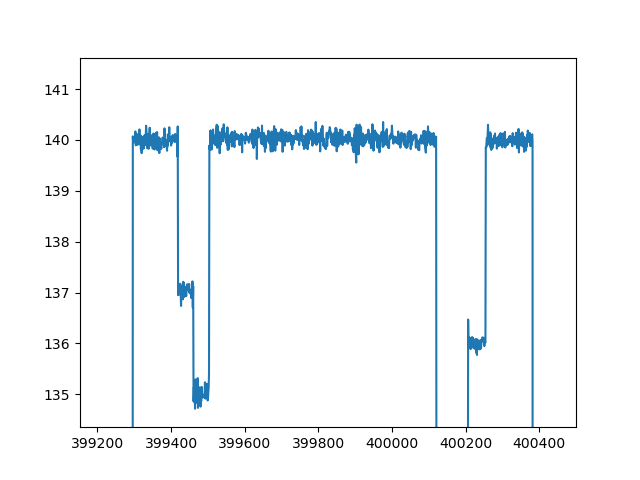

In [14]:
#recreate plots in matplotlib
plt.plot(df['sample_trace'])